In [1]:
import pandas as pd

# 1. Pandas로 데이터 불러오기
#### header = 0 은 파일의 첫 번째 줄에 열 이름이 있음을 나타내며, <br><br>delimeter = \t 는 필드가 탭으로 구분되는 것을 의미한다.<br> <br>quoting = 3 은 쌍따옴표를 무시하도록 한다.
#### ★QUOTE_MINIMAL(0) / ★QUOTE_ALL(1),<br><br>★QUOTE_NONNUMERIC(2) / ★QUOTE_NONE(3).

In [2]:
train = pd.read_csv('data/labeledTrainData.tsv', header = 0, delimiter='\t', quoting = 3)
test = pd.read_csv('data/testData.tsv', header = 0, delimiter='\t', quoting = 3)

In [3]:
train.shape

(25000, 3)

In [4]:
train.head()

,id,sentiment,review
0,"""5814_8""",1,"""With all this stuff going down at the moment ..."
1,"""2381_9""",1,"""\""The Classic War of the Worlds\"" by Timothy ..."
2,"""7759_3""",0,"""The film starts with a manager (Nicholas Bell..."
3,"""3630_4""",0,"""It must be assumed that those who praised thi..."
4,"""9495_8""",1,"""Superbly trashy and wondrously unpretentious ..."


In [5]:
test.shape

(25000, 2)

In [6]:
test.head()

,id,review
0,"""12311_10""","""Naturally in a film who's main themes are of ..."
1,"""8348_2""","""This movie is a disaster within a disaster fi..."
2,"""5828_4""","""All in all, this is a movie for kids. We saw ..."
3,"""7186_2""","""Afraid of the Dark left me with the impressio..."
4,"""12128_7""","""A very accurate depiction of small time mob l..."


In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 3 columns):
id           25000 non-null object
sentiment    25000 non-null int64
review       25000 non-null object
dtypes: int64(1), object(2)
memory usage: 586.0+ KB


In [8]:
train.describe()

,sentiment
count,25000.00000
mean,0.50000
std,0.50001
min,0.00000
25%,0.00000
50%,0.50000
75%,1.00000
max,1.00000


In [9]:
train.sentiment.value_counts()

1    12500
0    12500
Name: sentiment, dtype: int64

In [10]:
len(train['review'][0])

2304

# 2. NLP 텍스트 데이터 전처리
### 데이터 정제 Data Cleaning and Text Preprocessing
#### 기계가 텍스트를 이해할 수 있도록 텍스트를 정제해 준다.
#### 신호와 소음을 구분한다. 아웃라이어데이터로 인한 오버피팅을 방지한다.
#### 1. BeautifulSoup(뷰티풀숩)을 통해 HTML 태그를 제거 <br><br>2. 정규표현식으로 알파벳 이회의 문자를 공백으로 치환<br><br>3. NLTK 데이터를 사용해 불용어(Stopword)를 제거<br><br>4. 어간추출(스테밍 Stemming)과 음소표기법(Lemmatizing)의 개념을 이해하고 SnowballStemmer를 통해 어간 추출

In [11]:
#!pip show BeautifulSoup4

In [12]:
from bs4 import BeautifulSoup

In [13]:
# html 태그 정제
example1 = BeautifulSoup(train['review'][0], "html5lib")
print(train['review'][0][:700])
example1.get_text()[:700]

"With all this stuff going down at the moment with MJ i've started listening to his music, watching the odd documentary here and there, watched The Wiz and watched Moonwalker again. Maybe i just want to get a certain insight into this guy who i thought was really cool in the eighties just to maybe make up my mind whether he is guilty or innocent. Moonwalker is part biography, part feature film which i remember going to see at the cinema when it was originally released. Some of it has subtle messages about MJ's feeling towards the press and also the obvious message of drugs are bad m'kay.<br /><br />Visually impressive but of course this is all about Michael Jackson so unless you remotely lik


'"With all this stuff going down at the moment with MJ i\'ve started listening to his music, watching the odd documentary here and there, watched The Wiz and watched Moonwalker again. Maybe i just want to get a certain insight into this guy who i thought was really cool in the eighties just to maybe make up my mind whether he is guilty or innocent. Moonwalker is part biography, part feature film which i remember going to see at the cinema when it was originally released. Some of it has subtle messages about MJ\'s feeling towards the press and also the obvious message of drugs are bad m\'kay.Visually impressive but of course this is all about Michael Jackson so unless you remotely like MJ in anyw'

In [14]:
# 정규표현식을 사용해서 특수문자를 제거
import re
# 소문자와 대문자가 아닌 것은 공백으로 대체한다. (^ 은 not을 의미)
letters_only = re.sub('[^a-zA-Z]', ' ', example1.get_text())
letters_only[:700]

' With all this stuff going down at the moment with MJ i ve started listening to his music  watching the odd documentary here and there  watched The Wiz and watched Moonwalker again  Maybe i just want to get a certain insight into this guy who i thought was really cool in the eighties just to maybe make up my mind whether he is guilty or innocent  Moonwalker is part biography  part feature film which i remember going to see at the cinema when it was originally released  Some of it has subtle messages about MJ s feeling towards the press and also the obvious message of drugs are bad m kay Visually impressive but of course this is all about Michael Jackson so unless you remotely like MJ in anyw'

In [15]:
#모두 소문자로 변환한다.
lower_case = letters_only.lower()
#문자를 나눈다. => 토큰화
words = lower_case.split()
print(len(words))
words[:10]

437


['with',
 'all',
 'this',
 'stuff',
 'going',
 'down',
 'at',
 'the',
 'moment',
 'with']

### 불용어 제거(Stopword Removal)
#### 일반적으로 코퍼스에서 자주 나타나는 단어는 학습 모델로서 학습이나 예측 프로세스에 실제로<br><br> 기여하지 않아 다른 텍스트와 구별하지 못한다. 예를들어 조사, 접미사, i, me, my, it, this, that,<br><br> is, are 등과 같은 단어는 빈번하게 등장하지만 실제 의미를 찾는데 큰 기여를 하지 않는다.<br><br> Stopwords는 "to" 또는 "the"와 같은 용어를 포함하므로 사전 처리 단계에서 제거하는 것이 좋<br><br>다. NLTK에는 153 개의 영어 불용어가 미리 정의되어 있다. 17개의 언어에 대해 정의되어 있으며<br><br>한국어는 없다.

In [16]:
import nltk

In [17]:
#nltk.download('stopwords')

In [18]:
from nltk.corpus import stopwords
stopwords.words('english')

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [19]:
#stopwords 를 제거한 토큰들
words = [w for w in words if not w in stopwords.words('english')]
print(len(words))
words[:10]

219


['stuff',
 'going',
 'moment',
 'mj',
 'started',
 'listening',
 'music',
 'watching',
 'odd',
 'documentary']

### 어간 추출 (Stemming)
#### 어간 추출 : 어형이 변형된 단어로부터 접사 등을 제거하고 그 단어의 어간을 분리해 내는 것
#### "message", "messages', "messaging" 과 같이 복수형, 진행형 등의 문자를 같은 의미의 단어로 다룰 수 있도록 도와준다.
#### stemming(형태소 분석): 여기에서는 NLTK에서 제공하는 형태소 분석기를 사용한다.<br><br> 포터 형태소 분석기는 보수적이고 랭커스터 형태소 분석기는 좀 더 적극적이다.<br><br> 형태소 분석 규칙의 적극성 때문에 랭커스터 형태소 분석기는 더 많은 동음이의어 형태소를 생산한다.

In [20]:
# 포터 스태머의 사용 예
stemmer = nltk.stem.PorterStemmer()
print(stemmer.stem('maximum'))
print("The stemmed form of 'running' is: {}".format(stemmer.stem('running')))
print("The stemmed form of 'runs' is: {}".format(stemmer.stem('runs')))
print("The stemmed form of 'run' is: {}".format(stemmer.stem('run')))

maximum
The stemmed form of 'running' is: run
The stemmed form of 'runs' is: run
The stemmed form of 'run' is: run


In [21]:
# 랭커스터 스태머의 사용 예
from nltk.stem.lancaster import LancasterStemmer
lancaster_stemmer = LancasterStemmer()
print(lancaster_stemmer.stem('maximum'))
print("The stemmed form of 'running' is: {}".format(lancaster_stemmer.stem('running')))
print("The stemmed form of 'runs' is: {}".format(lancaster_stemmer.stem('runs')))
print("The stemmed form of 'run' is: {}".format(lancaster_stemmer.stem('run')))

maxim
The stemmed form of 'running' is: run
The stemmed form of 'runs' is: run
The stemmed form of 'run' is: run


In [22]:
# 처리 전 단어
words[:10]

['stuff',
 'going',
 'moment',
 'mj',
 'started',
 'listening',
 'music',
 'watching',
 'odd',
 'documentary']

In [23]:
from nltk.stem.snowball import SnowballStemmer

stemmer = SnowballStemmer('english')
words = [stemmer.stem(w) for w in words]

In [24]:
# 처리 후 단어
words[:10]

['stuff',
 'go',
 'moment',
 'mj',
 'start',
 'listen',
 'music',
 'watch',
 'odd',
 'documentari']

### 음소표기법 Lemmatization
#### 언어학에서 음소 표기법(또는 lemmatization)은 단어의 보조 정리 또는 사전 형식에 의해 식별되는 단일 항목으로 분석 될 수 있도록 굴절 된 형태의 단어를 그룹화하는 과정이다. 예를 들어 동음이의어가 문맥에 따라 다른 의미를 갖는데
#### 1) 배가 맛있다.<br><br>2) 배를 타는 것이 재미있다.<br><br>3) 평소보다 두 배로 많이 먹어서 배가 아프다.
#### 위에 있는 3개의 문장에 있는 "배"는 모두 다른 의미를 갖는다.<br><br>레마타이제이션은 이때 앞뒤 문맥을 보고 단어의 의미를 식별하는 것이다. 영어에서 meet는 <br><br>meeting으로 쓰였을 때 회의를 뜻하지만, meet일 때는 만나다는 뜻을 갖는데 그 단어가 명사로 <br><br>쓰였는지 동사로 쓰였는지에 따라 적합한 의미를 갖도록 추출하는 것이다.

In [25]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\shjeong\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [26]:
from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()

print(wordnet_lemmatizer.lemmatize('fly'))
print(wordnet_lemmatizer.lemmatize('flies'))

fly
fly


In [27]:
words = [wordnet_lemmatizer.lemmatize(w) for w in words]

#처리 후 단어
words[:10]

['stuff',
 'go',
 'moment',
 'mj',
 'start',
 'listen',
 'music',
 'watch',
 'odd',
 'documentari']

## 문자열 처리

In [28]:
def review_to_words(raw_review):
    # 1. HTML 제거
    review_text = BeautifulSoup(raw_review, 'html.parser').get_text()
    
    # 2. 영문자가 아닌 문자는 공백으로 변환
    letters_only = re.sub('[^a-zA-Z]', ' ', review_text)
    
    # 3. 소문자 변환
    words = letters_only.lower().split()
    
    # 4. 파이썬에서는 리스트보다 세트로 찾는게 훨씬 빠르다.
    # stopwords 를 세트로 변환한다.
    stops = set(stopwords.words('english'))
    
    #5. Stopwords 불용어 제거
    meaningful_words = [w for w in words if not w in stops]
    
    # 6. 어간 추출
    stemming_words = [stemmer.stem(w) for w in meaningful_words]
    
    # 7. 공백으로 구분된 문자열로 결합하여 결과를 반환
    return (' '.join(stemming_words))

In [29]:
clean_review = review_to_words(train['review'][0])
clean_review

'stuff go moment mj start listen music watch odd documentari watch wiz watch moonwalk mayb want get certain insight guy thought realli cool eighti mayb make mind whether guilti innoc moonwalk part biographi part featur film rememb go see cinema origin releas subtl messag mj feel toward press also obvious messag drug bad kay visual impress cours michael jackson unless remot like mj anyway go hate find bore may call mj egotist consent make movi mj fan would say made fan true realli nice actual featur film bit final start minut exclud smooth crimin sequenc joe pesci convinc psychopath power drug lord want mj dead bad beyond mj overheard plan nah joe pesci charact rant want peopl know suppli drug etc dunno mayb hate mj music lot cool thing like mj turn car robot whole speed demon sequenc also director must patienc saint came film kiddi bad sequenc usual director hate work one kid let alon whole bunch perform complex danc scene bottom line movi peopl like mj one level anoth think peopl stay

In [30]:
# 첫 번째 리뷰를 대상으로 전처리 해줬던 내용을 전체 텍스트 데이터를 대상으로 처리한다.
# 전체 리뷰 데이터 수 가져오기
num_reviews = len(train['review'])
num_reviews

25000

In [31]:
clean_train_reviews = []
for i in range(0, num_reviews):
    if i % 1000 == 0:
        print('Review {} of {} '. format(i+1, num_reviews))
    clean_train_reviews.append(review_to_words(train['review'][i]))

Review 1 of 25000 
Review 1001 of 25000 
Review 2001 of 25000 
Review 3001 of 25000 
Review 4001 of 25000 
Review 5001 of 25000 
Review 6001 of 25000 
Review 7001 of 25000 
Review 8001 of 25000 
Review 9001 of 25000 
Review 10001 of 25000 
Review 11001 of 25000 
Review 12001 of 25000 
Review 13001 of 25000 
Review 14001 of 25000 
Review 15001 of 25000 
Review 16001 of 25000 
Review 17001 of 25000 
Review 18001 of 25000 
Review 19001 of 25000 
Review 20001 of 25000 
Review 21001 of 25000 
Review 22001 of 25000 
Review 23001 of 25000 
Review 24001 of 25000 


In [32]:
clean_test_reviews = []
for i in range(0, num_reviews):
    if i % 5000 == 0:
        print('Review {} of {} '. format(i+1, num_reviews))
    clean_test_reviews.append(review_to_words(test['review'][i]))

Review 1 of 25000 
Review 5001 of 25000 
Review 10001 of 25000 
Review 15001 of 25000 
Review 20001 of 25000 


In [33]:
# # 참고 : https://gist.github.com/yong27/7869662
# # http://www.racketracer.com/2016/07/06/pandas-in-parallel/
# from multiprocessing import Pool
# import numpy as np

# def _apply_df(args):
#     df, func, kwargs = args
#     return df.apply(func, **kwargs)

# def apply_by_multiprocessing(df, func, **kwargs):
#     # 키워드 항목 중 workers 파라메터를 꺼냄
#     workers = kwargs.pop('workers')
#     # 위에서 가져온 workers 수로 프로세스 풀을 정의
#     pool = Pool(processes=workers)
#     # 실행할 함수와 데이터프레임을 워커의 수 만큼 나눠 작업
#     result = pool.map(_apply_df, [(d, func, kwargs)
#             for d in np.array_split(df, workers)])
#     pool.close()
#     # 작업 결과를 합쳐서 반환
#     return pd.concat(list(result))

In [34]:
# %time clean_train_reviews = apply_by_multiprocessing(\
#     train['review'], review_to_words, workers=4)

In [35]:
# %time clean_test_reviews = apply_by_multiprocessing(\
#     test['review'], review_to_words, workers=4)

In [36]:
clean_train_reviews[:10]

['stuff go moment mj start listen music watch odd documentari watch wiz watch moonwalk mayb want get certain insight guy thought realli cool eighti mayb make mind whether guilti innoc moonwalk part biographi part featur film rememb go see cinema origin releas subtl messag mj feel toward press also obvious messag drug bad kay visual impress cours michael jackson unless remot like mj anyway go hate find bore may call mj egotist consent make movi mj fan would say made fan true realli nice actual featur film bit final start minut exclud smooth crimin sequenc joe pesci convinc psychopath power drug lord want mj dead bad beyond mj overheard plan nah joe pesci charact rant want peopl know suppli drug etc dunno mayb hate mj music lot cool thing like mj turn car robot whole speed demon sequenc also director must patienc saint came film kiddi bad sequenc usual director hate work one kid let alon whole bunch perform complex danc scene bottom line movi peopl like mj one level anoth think peopl sta

## 워드 클라우드

In [37]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
%matplotlib inline

def displayWordCloud(data = None, backgroundcolor = 'white', width=800, height=600):
    wordcloud = WordCloud(stopwords = STOPWORDS,
                         background_color = backgroundcolor,
                         width = width, height=height).generate(data)
    plt.figure(figsize = (15,10))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()

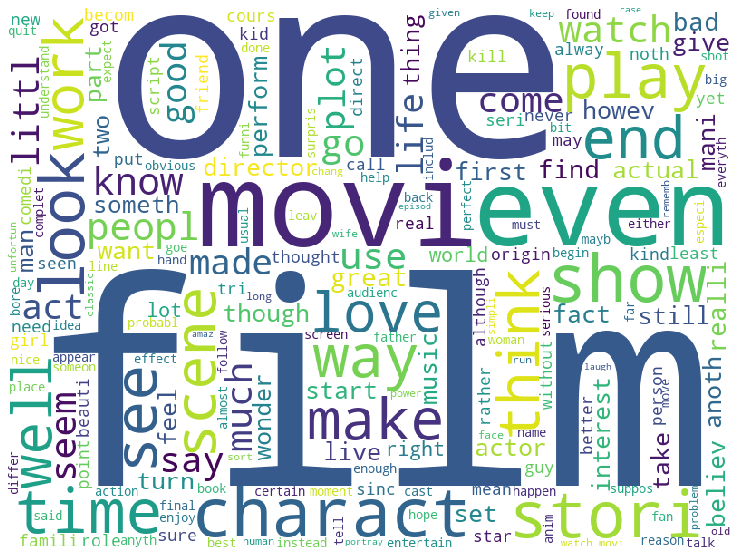

Wall time: 15.4 s


In [38]:
%time displayWordCloud(' '.join(clean_train_reviews))

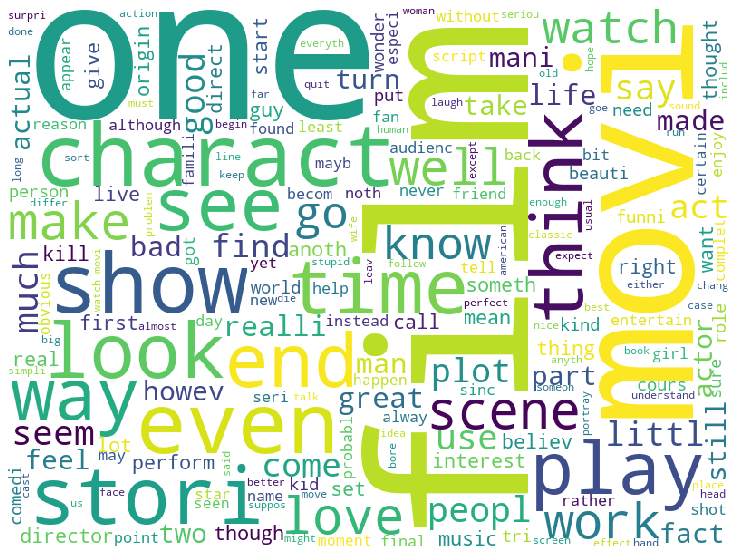

Wall time: 15.5 s


In [39]:
%time displayWordCloud(' '.join(clean_test_reviews))

In [40]:
count_words_f = lambda x: len(str(x).split())

train['num_words'] = list(map(count_words_f, clean_train_reviews))

count_uniq_words_f = lambda x: len(set(str(x).split()))

train['num_uniq_words'] = list(map(count_uniq_words_f, clean_train_reviews))

In [41]:
x = clean_train_reviews[0]
x = str(x).split()
print(len(x))
x[:10]

219


['stuff',
 'go',
 'moment',
 'mj',
 'start',
 'listen',
 'music',
 'watch',
 'odd',
 'documentari']

In [42]:
train.head()

,id,sentiment,review,num_words,num_uniq_words
0,"""5814_8""",1,"""With all this stuff going down at the moment ...",219,156
1,"""2381_9""",1,"""\""The Classic War of the Worlds\"" by Timothy ...",84,63
2,"""7759_3""",0,"""The film starts with a manager (Nicholas Bell...",240,201
3,"""3630_4""",0,"""It must be assumed that those who praised thi...",189,158
4,"""9495_8""",1,"""Superbly trashy and wondrously unpretentious ...",210,188


리뷰별 단어 평균 값 : 119.52356
리뷰별 단어 중간 값 : 89.0
리뷰별 고유 단어 평균 값 : 94.05756
리뷰별 고유 단어 중간 값 : 74.0


Text(0.5, 1.0, '리뷰별 고유한 단어 수 분포')

C:\Users\shjeong\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 47532 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\shjeong\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 48624 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\shjeong\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 48324 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\shjeong\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 45800 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\shjeong\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 50612 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\shjeong\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 49688 mi

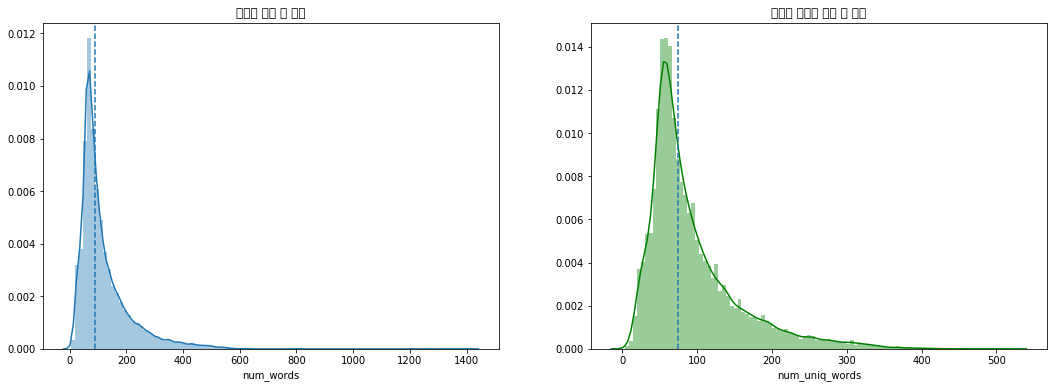

In [43]:
import seaborn as sns

fig, axes = plt.subplots(ncols=2)
fig.set_size_inches(18,6)
print('리뷰별 단어 평균 값 :', train['num_words'].mean())
print('리뷰별 단어 중간 값 :', train['num_words'].median())
sns.distplot(train['num_words'], bins=100, ax=axes[0])
axes[0].axvline(train['num_words'].median(), linestyle='dashed')
axes[0].set_title('리뷰별 단어 수 분포')

print('리뷰별 고유 단어 평균 값 :', train['num_uniq_words'].mean())
print('리뷰별 고유 단어 중간 값 :', train['num_uniq_words'].median())
sns.distplot(train['num_uniq_words'], bins=100, color = 'g', ax=axes[1])
axes[1].axvline(train['num_uniq_words'].median(), linestyle='dashed')
axes[1].set_title('리뷰별 고유한 단어 수 분포')

## Bag Of Words

In [44]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline

In [50]:
vectorizer = CountVectorizer(analyzer = 'word',
                             tokenizer = None,
                             preprocessor = None,
                             stop_words = None,
                             min_df = 2, # 토큰이 나타날 최소 문서 개수
                             ngram_range = (1, 3),
                             max_features = 20000
                            )
vectorizer

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=20000, min_df=2,
        ngram_range=(1, 3), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [51]:
# 속도 개선을 위해 파이프라인을 사용하여 개선
pipeline = Pipeline([
    ('vect', vectorizer),
])

In [52]:
%time train_data_features = pipeline.fit_transform(clean_train_reviews)
train_data_features

Wall time: 21.7 s


<25000x20000 sparse matrix of type '<class 'numpy.int64'>'
	with 2762268 stored elements in Compressed Sparse Row format>

In [53]:
train_data_features.shape

(25000, 20000)

In [55]:
vocab = vectorizer.get_feature_names()
print(len(vocab))
vocab[:10]

20000


['aag',
 'aaron',
 'ab',
 'abandon',
 'abbey',
 'abbi',
 'abbot',
 'abbott',
 'abc',
 'abduct']

In [58]:
import numpy as np
dist = np.sum(train_data_features, axis=0)

for tag, count in zip(vocab, dist):
    print(count, tag)
    
pd.DataFrame(dist, columns = vocab)

[[26 48 22 ... 59 40 23]] aag


,aag,aaron,ab,abandon,abbey,abbi,abbot,abbott,abc,abduct,...,zombi bloodbath,zombi film,zombi flick,zombi movi,zone,zoo,zoom,zorro,zu,zucker
0,26,48,22,288,24,30,29,30,125,55,...,23,52,37,89,161,31,71,59,40,23


In [60]:
pd.DataFrame(train_data_features[:10].toarray(), columns = vocab).head()

,aag,aaron,ab,abandon,abbey,abbi,abbot,abbott,abc,abduct,...,zombi bloodbath,zombi film,zombi flick,zombi movi,zone,zoo,zoom,zorro,zu,zucker
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [62]:
from sklearn.ensemble import RandomForestClassifier

# 랜덤 포레스트 분류기 사용
forest = RandomForestClassifier( # n_jobs = -1: 모든CPU 코어를 사용
    n_estimators = 100, n_jobs = -1, random_state = 2018)
forest

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=2018, verbose=0,
            warm_start=False)

In [64]:
%time forest = forest.fit(train_data_features, train['sentiment'])

Wall time: 8.39 s


In [65]:
from sklearn.model_selection import cross_val_score
%time score = np.mean(cross_val_score(\
    forest, train_data_features, \
    train['sentiment'], cv=10, scoring='roc_auc'))

Wall time: 1min 19s


In [67]:
clean_test_reviews[0]

'natur film main theme mortal nostalgia loss innoc perhap surpris rate high older viewer younger one howev craftsmanship complet film anyon enjoy pace steadi constant charact full engag relationship interact natur show need flood tear show emot scream show fear shout show disput violenc show anger natur joyc short stori lend film readi made structur perfect polish diamond small chang huston make inclus poem fit neat truli masterpiec tact subtleti overwhelm beauti'

In [68]:
%time test_data_features = pipeline.transform(clean_test_reviews)
test_data_features = test_data_features.toarray()

Wall time: 5.59 s


In [69]:
test_data_features

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [74]:
# 벡터화 된 단어로 숫자가 문서에서 등장하는 횟수를 나타낸다.
test_data_features[5][:100]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int64)

In [79]:
# 벡터화 하며 만든 사전에서 해당 단어가 무엇인지 찾아볼 수 있다.
# vocab = vectorizer.get_feature_names()
vocab[8], vocab[2558], vocab[2559], vocab[2560],vocab[19999]

('abc', 'charact person', 'charact play', 'charact plot', 'zucker')

In [76]:
len(vocab)

20000

In [80]:
# 테스트 데이터를 넣고 예측한다.
result = forest.predict(test_data_features)
result[:10]

array([1, 0, 0, 1, 1, 1, 0, 1, 0, 0], dtype=int64)

In [81]:
# 예측 결과를 저장하기 위해 데이터프레임에 담아 준다.
output = pd.DataFrame(data={'id':test['id'], 'sentiment':result})
output.head()

,id,sentiment
0,"""12311_10""",1
1,"""8348_2""",0
2,"""5828_4""",0
3,"""7186_2""",1
4,"""12128_7""",1


In [82]:
output.to_csv('data/tutorial_1_BOW_{0:.5f}.csv'.format(score), index=False, quoting=3)

In [87]:
output_sentiment = output['sentiment'].value_counts()
print(output_sentiment[0]-output_sentiment[1])

108


In [88]:
output_sentiment

0    12554
1    12446
Name: sentiment, dtype: int64

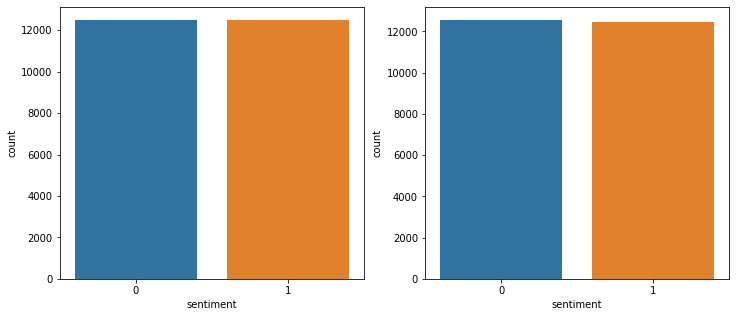

In [89]:
fig, axes = plt.subplots(ncols=2)
fig.set_size_inches(12,5)
sns.countplot(train['sentiment'], ax=axes[0])
sns.countplot(output['sentiment'], ax=axes[1])